In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import fftconvolve
import dask.array as da

In [4]:
c = 3e8
res_az = 150 # m   TODO find resolution along azimuth
res_rg = 150 # m   TODO make function of bandwith
n_scatterers_per_cell = 3
extent_rg = 600e3 # m 
extent_az = 50e3 # m
incidence_min = 29 # deg
x0, y0, z0 = 0, 0, 700e3 # m azimuth, range, altitude satellite
PRF = 5 # / s
vy_satellite, vx_satellite, vz_satellite = 0, 6800, 0 # m /s
distance_satellite = 25e3 # m 
n_bursts = int(np.floor(distance_satellite / vx_satellite * PRF))

n_scatterers_az = int(extent_az / res_az * n_scatterers_per_cell)
n_scatterers_rg = int(extent_rg / res_rg * n_scatterers_per_cell)

min_rg = np.tan(np.deg2rad(incidence_min))*z0
max_rg = min_rg + extent_rg
min_az, max_az = -extent_az/2, extent_az /2

seed = 42
np.random.seed(seed)
chunks_az = 50
chunks_rg = 50
chunks_time_slow = 1
rg_extent = da.from_array(np.linspace(start=min_rg, stop=max_rg, num=n_scatterers_rg), chunks = (chunks_rg))
az_extent = da.from_array(np.linspace(start=min_az, stop=max_az, num=n_scatterers_az), chunks = (chunks_az))

rg, az = np.meshgrid(rg_extent, az_extent)

In [5]:
time_slow = np.linspace(start=0, stop=n_bursts/PRF ,num=n_bursts)
amplitude = da.from_array(np.ones((rg.shape[0], rg.shape[1],  len(time_slow))), chunks=(chunks_az, chunks_rg, chunks_time_slow))
uniform_phase = da.from_array(np.random.rand(amplitude.size).reshape(amplitude.shape), chunks = (chunks_az, chunks_rg, chunks_time_slow))
scatter_phase = np.exp(1j*uniform_phase*2*np.pi)
velocity = np.ones_like(amplitude)

x_sat = x0 + time_slow * vx_satellite
y_sat = y0 + time_slow * vy_satellite
z_sat = z0 + time_slow * vz_satellite

In [6]:
ds = xr.Dataset(
    data_vars=dict(
        amplitude=(["x", "y", "time_slow"], amplitude), # TODO add rayleigh distributed amplitude
        velocity=(["x", "y", "time_slow"], velocity),
        scatter_phase=(["x", "y", "time_slow"], scatter_phase),
        # TODO add beam pattern 
        # TODO add realistic gradient based on CMOD
        x_sat=(["time_slow"], x_sat),
        y_sat=(["time_slow"], y_sat),
        z_sat=(["time_slow"], z_sat),

    ),
    coords=dict(
        rg=(["x", "y"], rg),
        az=(["x", "y"], az),
        time_slow=(["time_slow"], time_slow),
    ),
    attrs=dict(description="Simulated surface", 
               vx_sat=vx_satellite, 
))
ds

<xarray.Dataset>
Dimensions:        (x: 1000, y: 12000, time_slow: 18)
Coordinates:
    rg             (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    az             (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * time_slow      (time_slow) float64 0.0 0.2118 0.4235 ... 3.176 3.388 3.6
Dimensions without coordinates: x, y
Data variables:
    amplitude      (x, y, time_slow) float64 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    velocity       (x, y, time_slow) float64 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    scatter_phase  (x, y, time_slow) complex128 dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    x_sat          (time_slow) float64 0.0 1.44e+03 ... 2.304e+04 2.448e+04
    y_sat          (time_slow) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    z_sat          (time_slow) float64 7e+05 7e+05 7e+05 ... 7e+05 7e+05 7e+05
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [7]:
def calculate_distance(x, y, x0, y0):
    return np.sqrt((x - x0) ** 2 + (y - y0) ** 2)

ds['d_ground'] = calculate_distance(ds['az'], ds['rg'], ds['x_sat'], ds['y_sat'])
ds['R'] = calculate_distance(ds['d_ground'], ds['z_sat'], 0, 0)

pulse_time = xr.DataArray(np.linspace(0, 1e-4, 100), dims='pulse_time') 

travel_time = ds['R']/c
ds['fast_time'] = travel_time + pulse_time
ds['reflection'] = ds['amplitude']*pulse_time
ds = ds.chunk({'x': 25, 'y': 25, 'time_slow': 1, 'pulse_time':100})
ds

<xarray.Dataset>
Dimensions:        (x: 1000, y: 12000, time_slow: 18, pulse_time: 100)
Coordinates:
    rg             (x, y) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
    az             (x, y) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
  * time_slow      (time_slow) float64 0.0 0.2118 0.4235 ... 3.176 3.388 3.6
Dimensions without coordinates: x, y, pulse_time
Data variables:
    amplitude      (x, y, time_slow) float64 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    velocity       (x, y, time_slow) float64 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    scatter_phase  (x, y, time_slow) complex128 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    x_sat          (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    y_sat          (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    z_sat          (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    d_ground       (x, y, time_slow) float64 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    R              (x, y, time_slow) float64 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    fast_time      (x, y, time_slow, pulse_time) float64 dask.array<chunksize=(25, 25, 1, 100), meta=np.ndarray>
    reflection     (x, y, time_slow, pulse_time) float64 dask.array<chunksize=(25, 25, 1, 100), meta=np.ndarray>
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [8]:
new_dtype = 'float32'

# Create a new Dataset with the modified datatypes
ds = xr.Dataset({
    k: (v.astype('complex64') if v.dtype == 'complex128' else v.astype(new_dtype))
    for k, v in ds.data_vars.items()
})

In [99]:
# amplitude_reshaped = ds['amplitude'].values.reshape(-1, 1)
# pulse = np.linspace(0,100, 100)*np.ones((1, 100))

# reflection = fftconvolve(amplitude_reshaped, pulse, mode = 'full')

In [100]:
# amplitude_reshaped = ds['amplitude'].values.reshape(-1, 1)
# pulse = np.linspace(0,100, 100)*np.ones((1, 100))

# reflection = fftconvolve(amplitude_reshaped, pulse, mode = 'full')
# reflection = reflection.reshape(ds['amplitude'].values.shape+(pulse.shape[1],))

# ds['reflection'] = (["x", "y", "time_slow", "pulse_time"], reflection)
# ds['fast_time'] = (["x", "y", "time_slow", "pulse_time"], fast_time)

# ds = ds.isel(time_slow = slice(0,2))
# ds

In [101]:
# ds = ds[["reflection", "fast_time"]].astype('float32')
# ds = ds.chunk({'x': 25, 'y': 25, 'time_slow': 1, 'pulse_time':100})  # Adjust chunk sizes as needed

In [9]:
t_min = travel_time.min().values*1
t_max = travel_time.max().values*1 + pulse_time.max()
bins = np.linspace(t_min, t_max, 200)

In [17]:
t = ds.isel(time_slow=range(0,2))
t

<xarray.Dataset>
Dimensions:        (x: 1000, y: 12000, time_slow: 2, pulse_time: 100)
Coordinates:
    rg             (x, y) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
    az             (x, y) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
  * time_slow      (time_slow) float64 0.0 0.2118
Dimensions without coordinates: x, y, pulse_time
Data variables:
    amplitude      (x, y, time_slow) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    velocity       (x, y, time_slow) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    scatter_phase  (x, y, time_slow) complex64 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    x_sat          (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    y_sat          (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    z_sat          (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    d_ground       (x, y, time_slow) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    R              (x, y, time_slow) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    fast_time      (x, y, time_slow, pulse_time) float32 dask.array<chunksize=(25, 25, 1, 100), meta=np.ndarray>
    reflection     (x, y, time_slow, pulse_time) float32 dask.array<chunksize=(25, 25, 1, 100), meta=np.ndarray>

In [18]:
# def digitize_custom(da, bins):
#     return np.digitize(da, bins)

def searchsort_custom(da, bins):
    return np.searchsorted(bins, da)

t["index_digi"] = t[["fast_time"]].apply(searchsort_custom, bins=bins).fast_time
# t = xr.apply_ufunc(digitize_custom, test['fast_time'], bin_edges, vectorize=True, dask='parallelized', output_dtypes=[int])

In [19]:
t["index_digi"] = t["index_digi"].astype('int32').chunk({'x': 25, 'y': 25, 'time_slow': 1, 'pulse_time':100})
t

<xarray.Dataset>
Dimensions:        (x: 1000, y: 12000, time_slow: 2, pulse_time: 100)
Coordinates:
    rg             (x, y) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
    az             (x, y) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
  * time_slow      (time_slow) float64 0.0 0.2118
Dimensions without coordinates: x, y, pulse_time
Data variables:
    amplitude      (x, y, time_slow) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    velocity       (x, y, time_slow) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    scatter_phase  (x, y, time_slow) complex64 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    x_sat          (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    y_sat          (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    z_sat          (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    d_ground       (x, y, time_slow) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    R              (x, y, time_slow) float32 dask.array<chunksize=(25, 25, 1), meta=np.ndarray>
    fast_time      (x, y, time_slow, pulse_time) float32 dask.array<chunksize=(25, 25, 1, 100), meta=np.ndarray>
    reflection     (x, y, time_slow, pulse_time) float32 dask.array<chunksize=(25, 25, 1, 100), meta=np.ndarray>
    index_digi     (x, y, time_slow, pulse_time) int32 dask.array<chunksize=(25, 25, 1, 100), meta=np.ndarray>

In [20]:
# ds["index_digi"] = ds["index_digi"].astype('int32').chunk({'x': 25, 'y': 25, 'time_slow': 1, 'pulse_time':100})
# ds = ds.chunk({'x': 25, 'y': 25, 'time_slow': 1, 'pulse_time':100})
# ds

In [22]:
 #.sum(dim=('x', 'y'))
ds_sub = t.isel(time_slow=0)
reflections_grouped = ds_sub['reflection'].groupby(ds_sub['index_digi'])
reflection_total = reflections_grouped.sum().values

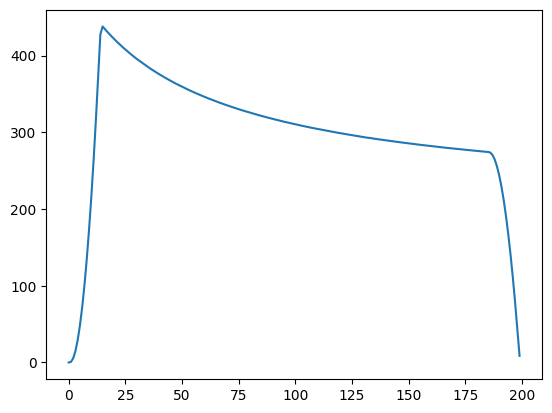

In [23]:
plt.plot(reflection_total)

## Test without numpy

In [82]:
pulse = np.linspace(1, 200, 200)
from scipy.signal import fftconvolve

data_variable = ds['amplitude']
kernel_variable = ds['pulse']

convolved_data = xr.apply_ufunc(
    fftconvolve,
    data_variable,
    kernel_variable,
    input_core_dims=[['x', 'y', 'time_slow'], ['time_fast']],
    output_core_dims=[['x', 'y', 'time_slow', 'time_fast']],
    vectorize=True,
    dask='parallelized',  # Use Dask for parallel processing if available
    output_dtypes=[float],
    output_sizes={
        'x': len(data_variable['x']),
        'y': len(data_variable['y']),
        'time_slow': len(data_variable['time_slow']),
        'time_fast': len(kernel_variable['time_fast']),
    }
)